In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Load the dataset and labels

In [31]:
data = pd.read_csv("task2_data.txt")
train_labels = pd.read_csv("task2_train_label.txt", header=None, sep="\t", names=["order", "label"])
valid_labels = pd.read_csv("task2_valid_label.txt", header=None, sep="\t", names=["order", "label"])
test_query = pd.read_csv("task2_test_query.txt",header=None, sep="\t", names=["order", "product"])

Add the attributes to the test, train and validation sets

In [43]:
train_df_original = data.merge(train_labels, on="order")
valid_df_original = data.merge(valid_labels, on="order")
test_df_original = data.merge(test_query, on=["order", "product"])

Create a copy for actual training

In [50]:
train_df = train_df_original.copy()
valid_df = valid_df_original.copy()
test_df = test_df_original.copy()

# Baseline - Filtering
To figure out a baseline without any machine learning model we can simply label products above a certain return rate to be likely to be returned.

In [80]:
def get_product_stats(df):
    product_stats = df.groupby('product').agg(
        total_count=('product', 'count'),
        return_1_or_2_count=('label', lambda x: x.isin([1, 2]).sum())
    ).reset_index(drop=True)
    product_stats['product'] = product_stats.index
    product_stats['return_rate'] = product_stats['return_1_or_2_count'] / product_stats['total_count']
    return product_stats

In [121]:
def create_return_df(df, labels):
    product_stats = get_product_stats(df)
    return_df = df.merge(product_stats["return_rate"], how='left', right_index=True, left_on='product')
    return_df['no_return_rate'] = 1 - return_df['return_rate']
    return return_df

In [150]:
train_return_df = create_return_df(train_df, train_labels)
valid_return_df = create_return_df(valid_df, valid_labels)

In [154]:
# Set the threshold to 0.5 and if below set predicted to 0
train_return_df['predicted'] = np.where(train_return_df['return_rate'] > 0.5, 1, 0)
valid_return_df['predicted'] = np.where(valid_return_df['return_rate'] > 0.5, 1, 0)

In [157]:
train_return_df["correct"] = train_return_df["predicted"] == train_return_df["label"]
valid_return_df["correct"] = valid_return_df["predicted"] == valid_return_df["label"]

In [159]:
train_accuracy = train_return_df["correct"].sum() / train_return_df["correct"].count()
valid_accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()
train_accuracy, valid_accuracy

(0.4987971368079539, 0.49712946969245736)

# Baseline - SGD Classifier

In [181]:
train_return_df = create_return_df(train_df, train_labels).dropna()
valid_return_df = create_return_df(valid_df, valid_labels).dropna()

In [196]:
train_return_df.columns

Index(['order', 'product', 'customer', 'color', 'size', 'group', 'label',
       'return_rate', 'no_return_rate', 'predicted', 'correct'],
      dtype='object')

In [197]:
from sklearn.linear_model import SGDClassifier

features = ['return_rate']
X_train = train_return_df[features]
y_train = train_return_df['label']
X_valid = valid_return_df[features]
y_valid = valid_return_df['label']

clf = SGDClassifier()
clf.fit(X_train, y_train)

SGDClassifier()

In [198]:
train_return_df['predicted'] = clf.predict(X_train)
valid_return_df['predicted'] = clf.predict(X_valid)

In [199]:
train_return_df["correct"] = train_return_df["predicted"] == train_return_df["label"]
valid_return_df["correct"] = valid_return_df["predicted"] == valid_return_df["label"]   

train_accuracy = train_return_df["correct"].sum() / train_return_df["correct"].count()
valid_accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()

train_accuracy, valid_accuracy

(0.523042147566936, 0.5132298241081351)

In [200]:
train_return_df["predicted"].value_counts()

predicted
1    4687649
Name: count, dtype: int64

In [201]:
train_return_df["label"].value_counts()

label
1    2451838
0    2235811
Name: count, dtype: int64

<Axes: >

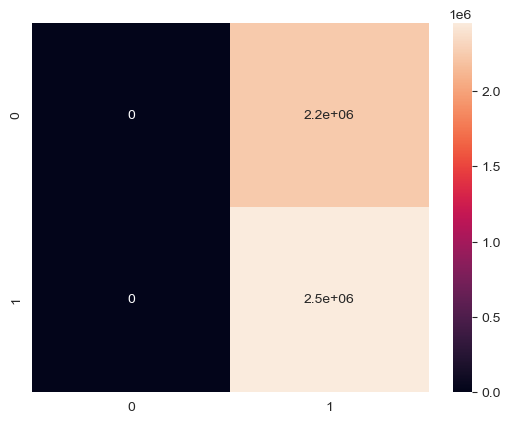

In [205]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_matrix_train = confusion_matrix(train_return_df["label"], train_return_df["predicted"])
confusion_matrix_valid = confusion_matrix(valid_return_df["label"], valid_return_df["predicted"])

sns.heatmap(confusion_matrix_train, annot=True)

# Baseline - Random Forest Classifier

In [206]:
train_return_df = create_return_df(train_df, train_labels).dropna()
valid_return_df = create_return_df(valid_df, valid_labels).dropna()

In [209]:
features = ['return_rate', 'no_return_rate']

X_train = train_return_df[features]
y_train = train_return_df['label']

X_valid = valid_return_df[features]
y_valid = valid_return_df['label']

clf = RandomForestClassifier(verbose = 1, n_jobs=5)

clf.fit(X_train, y_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   59.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  2.4min finished


RandomForestClassifier(n_jobs=5, verbose=1)

In [210]:
train_return_df['predicted'] = clf.predict(X_train)
valid_return_df['predicted'] = clf.predict(X_valid)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    2.0s finished


In [211]:
train_return_df["correct"] = train_return_df["predicted"] == train_return_df["label"]
valid_return_df["correct"] = valid_return_df["predicted"] == valid_return_df["label"]

train_accuracy = train_return_df["correct"].sum() / train_return_df["correct"].count()
valid_accuracy = valid_return_df["correct"].sum() / valid_return_df["correct"].count()

train_accuracy, valid_accuracy

(0.5389354023733433, 0.511272622138015)

In [212]:
train_return_df["predicted"].value_counts()

predicted
1    3796909
0     890740
Name: count, dtype: int64

In [213]:
train_return_df["label"].value_counts()

label
1    2451838
0    2235811
Name: count, dtype: int64

<Axes: >

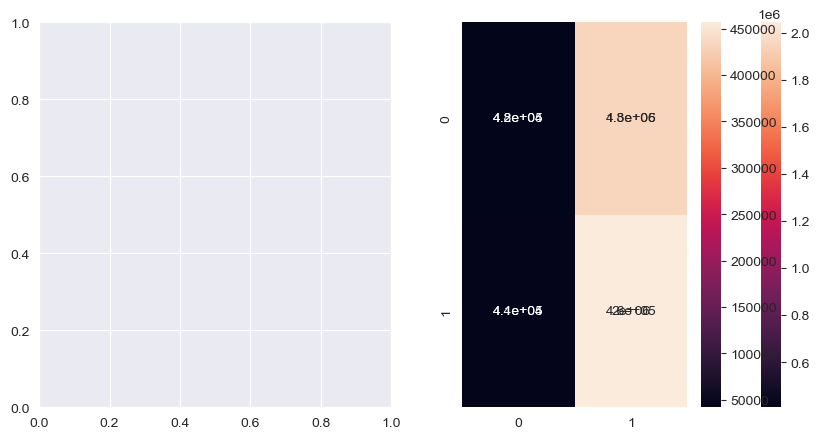

In [214]:
confusion_matrix_train = confusion_matrix(train_return_df["label"], train_return_df["predicted"])
confusion_matrix_valid = confusion_matrix(valid_return_df["label"], valid_return_df["predicted"])

plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(confusion_matrix_train, annot=True)
sns.heatmap(confusion_matrix_valid, annot=True)